In [2]:
from collections import defaultdict
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
from pymatgen.core import Composition, Element, Structure
from scipy.interpolate import interp1d

InteractiveShell.instance().ast_node_interactivity = "all"

In [84]:
from typing import Optional, Union

import numpy as np


def is_empty_list(x):
    return isinstance(x, str) and x == '[]'


def convert_mass_magnetization(
    comp: Composition,
    mass_magnetization: Union[float, np.ndarray],
    cgs_to_si: bool = True
) -> Union[float, np.ndarray]:
    """
    转换质量磁化率的单位，根据布尔参数决定转换方向。
    支持 mass_magnetization 为标量或 numpy 数组的情况。

    参数:
        comp: pymatgen.core.composition.Composition
            物质的化学组成，用于计算摩尔质量 (g/mol)。
        mass_magnetization: float 或 numpy.ndarray
            - 当 cgs_to_si 为 True 时，表示 CGS 制的质量磁化率 (emu/g)；
            - 当 cgs_to_si 为 False 时，表示 SI 制的摩尔磁矩 (A·m²/mol)。
            可以是单个浮点数，也可以是 numpy 数组。
        cgs_to_si: bool, 默认 True
            转换方向选择：
                True  : 从 CGS (emu/g) 转换到 SI (A·m²/mol)
                False : 从 SI (A·m²/mol) 转换到 CGS (emu/g)

    返回:
        float 或 numpy.ndarray:
            转换后的磁化率数值。
            - 如果 cgs_to_si=True，单位为 A·m²/mol；
            - 如果 cgs_to_si=False，单位为 emu/g。
            如果输入是 numpy 数组，则返回相同形状的 numpy 数组；
            如果输入是标量，则返回标量浮点数。
    """
    # 计算摩尔质量 (g/mol)
    molar_mass = comp.weight  # g/mol

    # 将输入转为 numpy 数组以便支持数组运算
    mm_arr = np.asarray(mass_magnetization, dtype=float)

    if cgs_to_si:
        # 从 CGS 转换到 SI:
        # mass_magnetization (emu/g) * molar_mass (g/mol) = emu/mol
        # 1 emu = 1e-3 A·m², 所以转换为 SI 得到 A·m²/mol
        result_arr = mm_arr * molar_mass * 1e-3
    else:
        # 从 SI 转换到 CGS:
        # mass_magnetization 表示 SI 制 (A·m²/mol)
        # 先转换为 emu/mol: 1 A·m² = 1e3 emu, 然后除以 molar_mass (g/mol) 得到 emu/g
        result_arr = mm_arr * 1e3 / molar_mass

    # 如果输入是标量 (0 维数组)，将结果转回浮点数
    if result_arr.ndim == 0:
        return float(result_arr)
    return result_arr


def convert_composition(comp: str) -> Optional[Composition]:
    try:
        c = Composition(comp)
        if len(c) == 0:
            return None
        return c
    except Exception:
        return None


def format_title(
    text: str,
    to_snake: bool = False,
    skip_list: Optional[list[str]] = None
) -> str:
    """
    格式化输入文本为首字母大写格式或蛇形命名法，并支持指定不需要格式化的单词。

    参数:
        text : str
            输入文本。
        to_snake : bool, 可选
            是否转换为蛇形命名法，默认为 False。
        skip_list : list[str], 可选
            指定部分单词不做格式化，默认为 None。

    返回:
        str
            格式化后的文本。
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    if text is None or text.strip() == "":
        return text

    if skip_list is None:
        skip_list = []

    if to_snake:
        # 将空格拆分为单词，并转换为蛇形命名法，保留skip_list中的单词不变
        words = text.strip().split()
        formatted = [word if word in skip_list else word.lower() for word in words]
        return "_".join(formatted)
    else:
        # 将下划线替换为空格，并分割成单词
        words = text.replace("_", " ").strip().split()
        if not words:
            return text
        # 格式化：第一个单词首字母大写，其他单词全部小写（除非在skip_list中）
        formatted = []
        for i, word in enumerate(words):
            if word in skip_list:
                formatted.append(word)
            else:
                formatted.append(word.capitalize() if i == 0 else word.lower())
        return " ".join(formatted)

In [4]:
from typing import Literal, Optional

import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter


class InterpSmooth:
    """
    A class for 1D linear interpolation of (x, y) → x_new, plus optional smoothing.
    Supported smoothing methods: "savgol", "gaussian", "moving average", or None.
    Default smooth_method is "savgol".

    Parameters
    ----------
    x : np.ndarray
        1D array of original x-values (e.g., energy – E_f). Must be sorted in ascending
        and already restricted to the interval of interest.
    y : np.ndarray
        1D array of original y-values corresponding to x. Length must match len(x).
    smooth_method : Literal["savgol", "gaussian", "moving average"] or None, default="savgol"
        - "savgol":         apply a Savitzky–Golay filter after interpolation.
        - "gaussian":       apply a Gaussian‐kernel convolution after interpolation.
        - "moving average": apply a fixed-window moving-average filter after interpolation.
        - None:             do not apply any smoothing (return raw interpolation).
    """
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        smooth_method: Optional[Literal["savgol", "gaussian", "moving average"]] = "savgol"
    ):
        # Convert inputs to numpy arrays
        self.x = np.asarray(x)
        self.y = np.asarray(y)

        # Basic sanity checks
        if self.x.ndim != 1 or self.y.ndim != 1:
            raise ValueError("Input x and y must be 1D arrays.")
        if self.x.shape[0] != self.y.shape[0]:
            raise ValueError("x and y must have the same length.")

        # Ensure x is strictly increasing; if not, sort
        if not np.all(np.diff(self.x) > 0):
            idx_sort = np.argsort(self.x)
            self.x = self.x[idx_sort]
            self.y = self.y[idx_sort]

        # Validate the smoothing method
        valid_methods = {"savgol", "gaussian", "moving average", None}
        if smooth_method not in valid_methods:
            raise ValueError(
                f"smooth_method must be one of {valid_methods}, got '{smooth_method}'"
            )
        self.smooth_method = smooth_method

    def __call__(self, x_new, s_factor: float = 0.0, normalize: bool = False) -> np.ndarray:
        """
        Interpolate (self.x, self.y) onto x_new via linear interpolation,
        then optionally apply smoothing as specified by smooth_method and s_factor.
        Finally, if normalize=True, scale the output so that its maximum absolute value is 1.

        Parameters
        ----------
        x_new : array_like
            1D array of x-coordinates where we want interpolated (and possibly smoothed) y-values.
            Must be strictly increasing and uniformly spaced.
        s_factor : float, default=0.0
            - If s_factor <= 0.0: no smoothing → return raw interpolated y.
            - If smooth_method == "savgol": s_factor is treated as window length in x-units.
              Internally, window_points = int(s_factor / dx), forced to be an odd integer ≥ 3.
            - If smooth_method == "gaussian": s_factor is interpreted as Gaussian sigma in x-units.
              Internally, sigma_pts = s_factor / dx (points). If sigma_pts ≤ 0, no smoothing.
            - If smooth_method == "moving average": s_factor is treated as window length in x-units.
              Internally, window_points = int(s_factor / dx). If window_points ≤ 1, no smoothing.
        normalize : bool, default=False
            If True, after interpolation (and smoothing), divide the output array by its maximum
            absolute value. If the maximum is zero, it returns the array unchanged to avoid division by zero.

        Returns
        -------
        y_out : np.ndarray
            1D array of length len(x_new). Either raw interpolated values
            (if no smoothing), or smoothed values after applying the chosen method.
            If normalize=True, the result is scaled so that max(abs(y_out)) == 1.
        """
        # Convert x_new to numpy and basic checks
        x_new_arr = np.asarray(x_new)
        if x_new_arr.ndim != 1 or x_new_arr.shape[0] < 2:
            raise ValueError("x_new must be a 1D array with at least two points.")
        if not np.all(np.diff(x_new_arr) > 0):
            raise ValueError("x_new must be strictly increasing and uniformly spaced.")

        # STEP 1: Linear interpolation
        y_interp = np.interp(x_new_arr, self.x, self.y)

        # STEP 2: If no smoothing requested, or s_factor <= 0, assign raw interpolation
        if self.smooth_method is None or s_factor <= 0.0:
            y_out = y_interp
        else:
            # Compute dx from x_new (assumes uniform spacing)
            dx = x_new_arr[1] - x_new_arr[0]
            if dx <= 0:
                raise ValueError("x_new must be strictly increasing with positive spacing.")

            # ------------------------------------------------------------------
            #  Savitzky–Golay smoothing
            # ------------------------------------------------------------------
            if self.smooth_method == "savgol":
                # Interpret s_factor as window length in x-units → convert to number of points
                win_pts = int(s_factor / dx)

                # Enforce minimum odd window length (≥ 3)
                if win_pts < 3:
                    # Too small: skip smoothing
                    y_out = y_interp
                else:
                    if win_pts % 2 == 0:
                        win_pts += 1  # make it odd

                    # Choose polynomial order (must be < win_pts). Here polyorder=2 by default.
                    polyorder = 2
                    if win_pts <= polyorder:
                        # Window too small to support polyorder
                        y_out = y_interp
                    else:
                        # Apply Savitzky–Golay filter
                        y_out = savgol_filter(
                            y_interp,
                            window_length=win_pts,
                            polyorder=polyorder,
                            mode='interp'
                        )

            # ------------------------------------------------------------------
            #  Gaussian Filter smoothing
            # ------------------------------------------------------------------
            elif self.smooth_method == "gaussian":
                # Interpret s_factor as sigma in x-units
                sigma_pts = s_factor / dx
                if sigma_pts <= 0:
                    # No smoothing
                    y_out = y_interp
                else:
                    # Apply 1D Gaussian filter (mode='nearest' to handle boundaries)
                    y_out = gaussian_filter1d(y_interp, sigma=sigma_pts, mode='nearest')

            # ------------------------------------------------------------------
            #  Moving-average smoothing
            # ------------------------------------------------------------------
            elif self.smooth_method == "moving average":
                # Interpret s_factor as window length in x-units → convert to number of points
                n_conv = int(s_factor / dx)
                if n_conv <= 1:
                    # Too small: skip smoothing
                    y_out = y_interp
                else:
                    # Build uniform boxcar kernel and convolve
                    kernel = np.ones(n_conv, dtype=np.float64) / n_conv
                    y_out = np.convolve(y_interp, kernel, mode="same")

            # ------------------------------------------------------------------
            #  Should not reach here due to validation in __init__
            # ------------------------------------------------------------------
            else:
                raise RuntimeError(f"Unsupported smoothing method '{self.smooth_method}'")

        # STEP 3: Normalize if requested
        if normalize:
            max_val = np.max(np.abs(y_out))
            if max_val > 0:
                y_out = y_out / max_val

        return y_out

#### QC AC data

In [106]:
qc_ac_dataset = pd.read_csv('../raw/HYPOD-X_20250121/properties_dataset.csv').dropna().drop(columns=['sample_name', 'figure_id', 'degree_of_approximant', 'SID'])
qc_ac_dataset = qc_ac_dataset.rename(columns={'composition': 'formula', 'QC_or_AC_type': 'hypermaterial_type'})

# Drop Specific heat since these value is to describe the temperature derivative of the molar heat capacity or the second-order temperature effects
qc_ac_dataset = qc_ac_dataset[~qc_ac_dataset.prop_y.isin(['Specific heat', 'Specific heat capacity', 'Hall coefficient', 'ZT', 'Power factor', 'Thermal diffusivity'])]

# Try to convert the composition string to the Composition object
qc_ac_dataset = qc_ac_dataset.assign(composition=qc_ac_dataset['formula'].apply(convert_composition)).dropna()
qc_ac_dataset = qc_ac_dataset.assign(elements=qc_ac_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements])))

# Align unit of Magnetic susceptibility
tmp = qc_ac_dataset[qc_ac_dataset.unit_y == 'emu*g^(-1)']
tmp = tmp.assign(
    unit_y='A*m**2/mol',
    y=[convert_mass_magnetization(comp, y) for comp, y in zip(tmp.composition, tmp.y)]
)
qc_ac_dataset.update(tmp)


qc_ac_dataset.unit_y.unique()
qc_ac_dataset.prop_y.unique()
qc_ac_dataset.shape
qc_ac_dataset.head(3)

array(['Ohm*m', 'W*m^(-1)*K^(-1)', 'V*K^(-1)', 'A*m**2/mol'], dtype=object)

array(['Electrical resistivity', 'Thermal conductivity',
       'Seebeck coefficient', 'Magnetic susceptibility'], dtype=object)

(48405, 12)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,9.608498,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
1,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,19.835030,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"
2,Y12Mg29Zn59,IQC,Temperature,Electrical resistivity,K,Ohm*m,31.782880,0.000002,17976,10.1063/1.1406555,"(Y, Mg, Zn)","(Y, Mg, Zn)"


In [135]:
start, end = 1.0, 800.
x_new = np.linspace(start, end, 500) # pre-selected range = (-6,5, 10.5).

y_new_list = defaultdict(list)
qc_ac_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in qc_ac_dataset.groupby(['formula', 'prop_y', 'sample_id']):
    if (f_, p_) == (f, p):
        continue
    f_, p_ = f, p

    interp = InterpSmooth(data.x.to_numpy(), data.y.to_numpy(), smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=25.0, normalize=True)

    tmp = data.iloc[0].copy()
    tmp.x = data.x.tolist()
    tmp.y = data.y.tolist()
    tmp['temperature'] = x_new.tolist()
    tmp['property_value'] = y_sgol.tolist()

    qc_ac_dataset_rebuild.append(tmp)

qc_ac_dataset_rebuild = pd.DataFrame(qc_ac_dataset_rebuild).rename(
    columns={'prop_y': 'property', 'unit_y': 'unit', 'x': 'raw_x', 'y': 'raw_y'}
).drop(columns=['prop_x', 'unit_x'])

qc_ac_dataset_rebuild = qc_ac_dataset_rebuild.set_index([[f'qa-{i}' for i in qc_ac_dataset_rebuild.index]], drop=True)
qc_ac_dataset_rebuild.head(3)
qc_ac_dataset_rebuild.shape
qc_ac_dataset_rebuild.property.value_counts()

qc_ac_dataset_rebuild.to_pickle('../processed_qc_ac_dataset_norm_20250121.pd.xz')

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
qa-34653,Al61.5Cu26.5Fe12,IQC,Seebeck coefficient,V*K^(-1),"[100.253, 122.1073, 139.211, 159.1709, 180.081...","[-1.04e-05, -1.08e-05, -1.12e-05, -1.13e-05, -...",57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[-0.765735205573575, -0.765735205573575, -0.76..."
qa-33657,Al61.5Cu26.5Fe12,IQC,Thermal conductivity,W*m^(-1)*K^(-1),"[287.8403, 372.7768, 468.6025, 575.3176, 673.3...","[1.416235, 1.7962, 2.970639, 4.317789, 5.80310...",57966,10.1007/s11664-014-3204-4,"(Al, Cu, Fe)","(Al, Cu, Fe)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[0.17674107690063748, 0.17674107690063748, 0.1..."
qa-6872,Ag42.25In42.25Yb15.5,IQC,Electrical resistivity,Ohm*m,"[5.68044, 12.19651, 18.7126, 25.22901, 31.7462...","[2.26e-06, 2.26e-06, 2.26e-06, 2.26e-06, 2.26e...",35352,10.1103/physrevb.72.054202,"(Ag, In, Yb)","(Ag, In, Yb)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[0.9997953280448494, 0.9997953280448494, 0.999..."


(699, 12)

property
Electrical resistivity     385
Seebeck coefficient        147
Thermal conductivity       116
Magnetic susceptibility     51
Name: count, dtype: int64

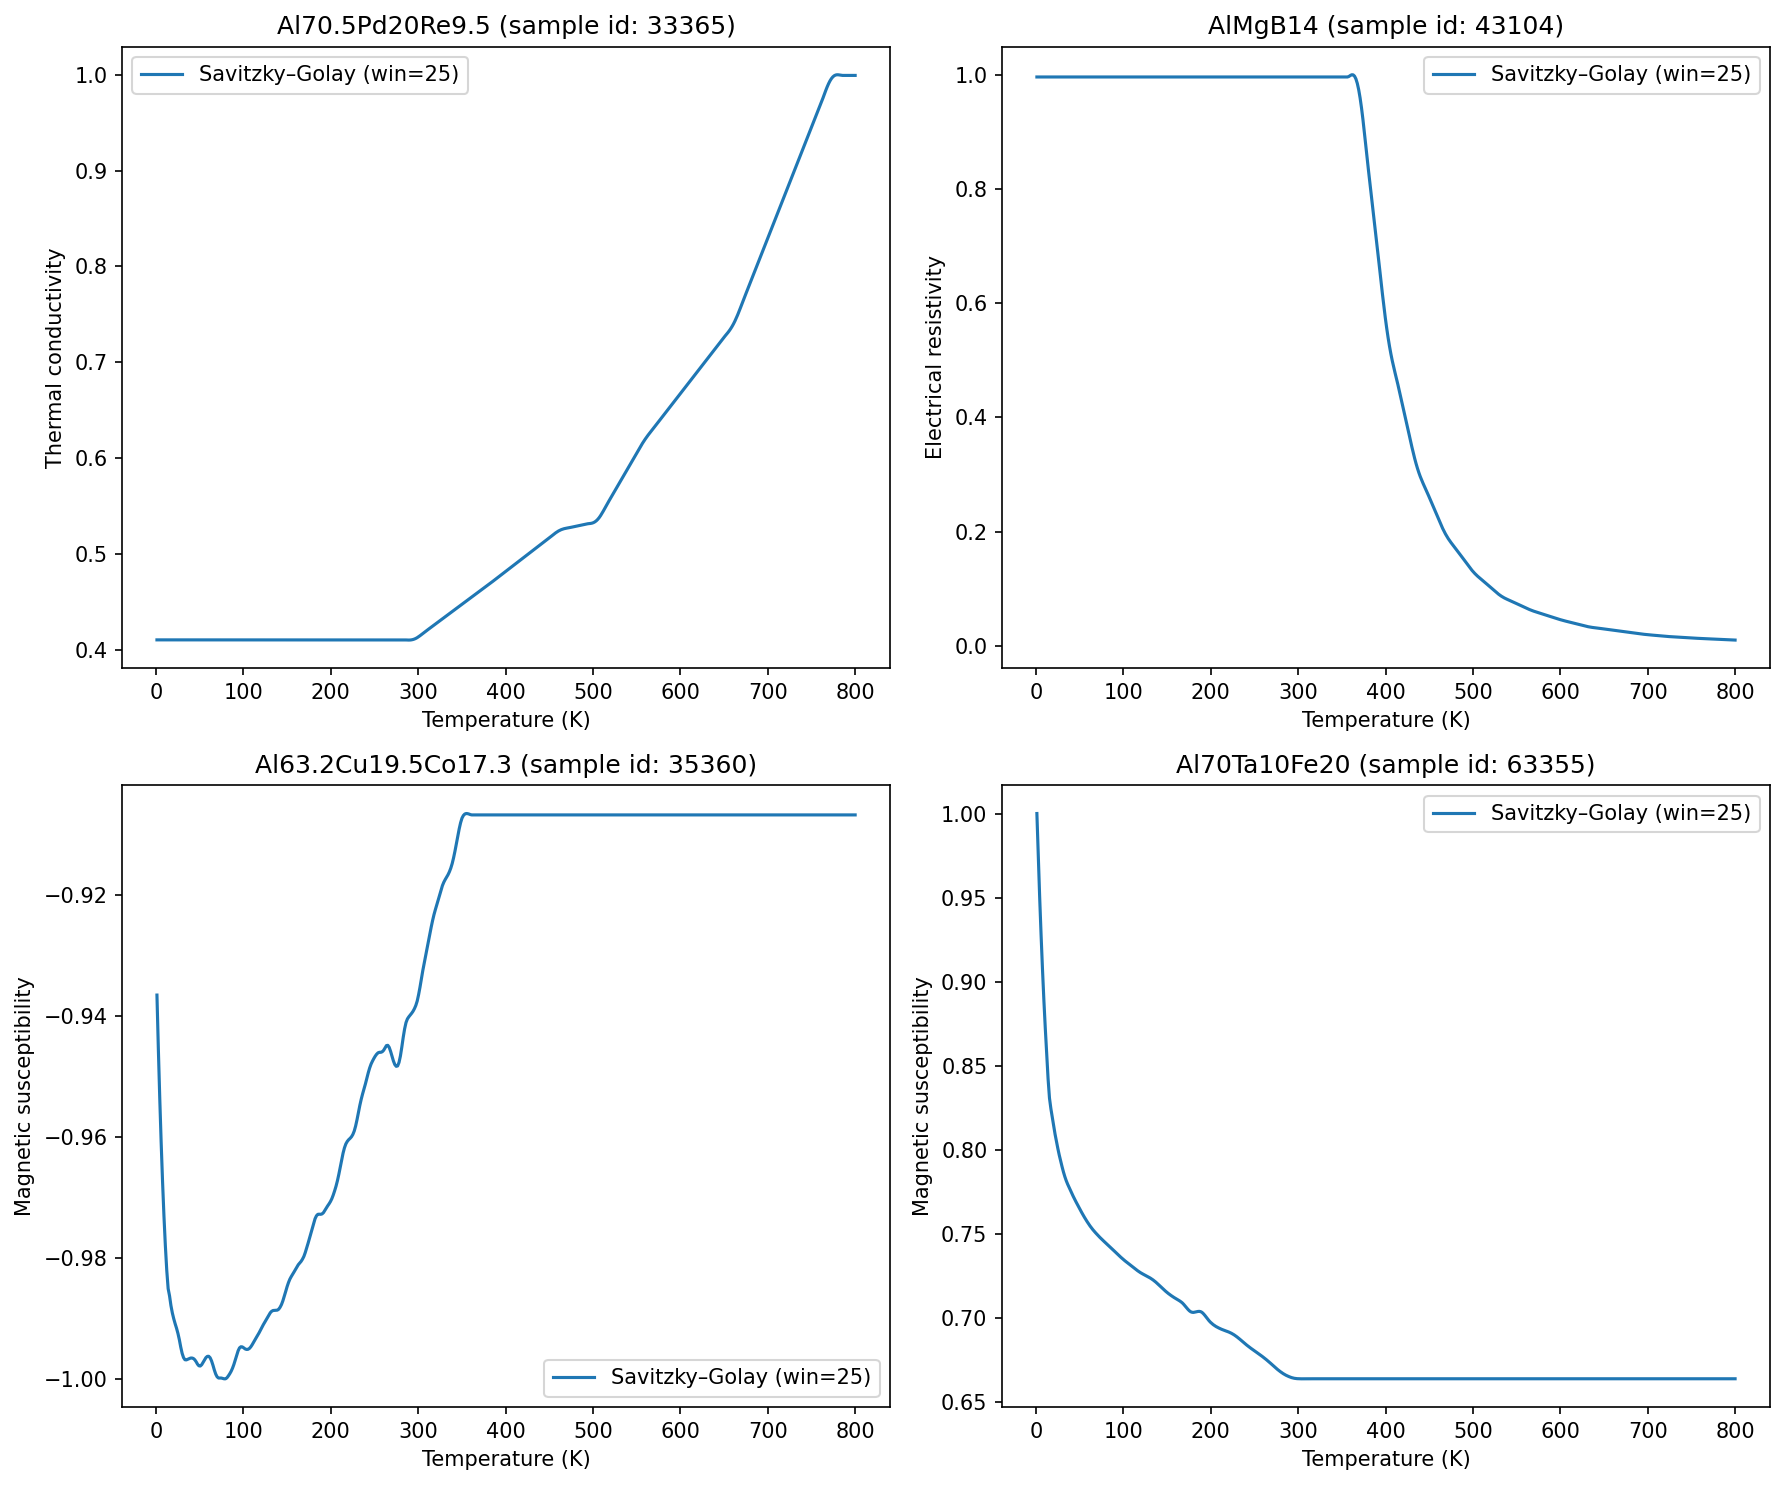

In [137]:
np.random.seed(4)  # 设置随机种子
random_indices = np.random.choice(len(qc_ac_dataset_rebuild), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = qc_ac_dataset_rebuild.iloc[i]
    y_new = tmp.property_value

    # _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, 'o', label='Original discrete data')
    _ = axes[idx].plot(x_new, y_new, '-', lw=1.5, label='Savitzky–Golay (win=25)')
    _ = axes[idx].set_xlabel('Temperature (K)')
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc='best')
    _ = axes[idx].set_title(f'{tmp.formula} (sample id: {tmp.sample_id})')

plt.tight_layout()
plt.show()


#### starry data

In [ ]:
starry_dataset = pd.read_csv('../raw/starrydata_dataset_20250531/starrydata_curves.csv')
mask = starry_dataset.map(is_empty_list)
rows_to_drop = mask.any(axis=1)
starry_dataset = starry_dataset[~rows_to_drop]

starry_dataset = starry_dataset.rename(columns={'composition': 'formula'})
starry_dataset = starry_dataset.assign(
    prop_x=starry_dataset.prop_x.apply(lambda s: format_title(s, to_snake=False)),
    prop_y=starry_dataset.prop_y.apply(lambda s: format_title(s, to_snake=False, skip_list=['ZT'])),
    unit_x=starry_dataset.unit_x.apply(lambda s: format_title(s, to_snake=False)),
    unit_y=starry_dataset.unit_y.apply(lambda s: format_title(s, to_snake=False)),
    x=starry_dataset.x.apply(eval),
    y=starry_dataset.y.apply(eval),
)

# Drop extremely small data
starry_dataset = starry_dataset[starry_dataset.unit_x == 'K']
starry_dataset = starry_dataset[~starry_dataset.unit_y.isin(['V', 'V/k'])]
starry_dataset = starry_dataset[starry_dataset.prop_y.isin(['Seebeck coefficient', 'Thermal conductivity', 'Electrical resistivity', 'Magnetic susceptibility'])]
starry_dataset = starry_dataset[starry_dataset.prop_y.isin(starry_dataset.prop_y.unique()[starry_dataset.prop_y.value_counts() >= 100])]

starry_dataset = starry_dataset[~starry_dataset.sample_id.isin([int(i) for i in qc_ac_dataset.sample_id if not i.startswith('hmt')])].assign(hypermaterial_type='others')
starry_dataset = starry_dataset[[
    'formula', 'hypermaterial_type', 'prop_x', 'prop_y', 'unit_x', 'unit_y', 'x', 'y', 'sample_id', 'DOI'
]].dropna()

# Try to convert the composition string to the Composition object
starry_dataset = starry_dataset.assign(composition=starry_dataset['formula'].apply(convert_composition)).dropna(subset=['composition'])
starry_dataset = starry_dataset.assign(elements=starry_dataset.composition.apply(lambda c: tuple([str(e) for e in c.elements])))

# Align unit of Magnetic susceptibility
tmp = starry_dataset[(starry_dataset.unit_y == 'emu*g^(-1)') | (starry_dataset.unit_y == 'Emu/g')]
tmp = tmp.assign(
    unit_y='A*m**2/mol',
    y=[convert_mass_magnetization(comp, y).tolist() for comp, y in zip(tmp.composition, tmp.y)]
)
starry_dataset.update(tmp)

starry_dataset.unit_y.unique()
starry_dataset.prop_y.unique()
starry_dataset.head(3)
starry_dataset.shape

array(['V*k^(-1)', 'W*m^(-1)*k^(-1)', 'Ohm*m', 'A*m**2/mol'], dtype=object)

array(['Seebeck coefficient', 'Thermal conductivity',
       'Electrical resistivity', 'Magnetic susceptibility'], dtype=object)

,formula,hypermaterial_type,prop_x,prop_y,unit_x,unit_y,x,y,sample_id,DOI,composition,elements
0,Pb1.00025Zn0.02Te1.02I0.0005,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[299.8597, 324.8683, 349.8757, 375.2454, 399.8...","[-0.0001484452, -0.0001602763, -0.0001729511, ...",113,10.1021/am405410e,"(Pb, Zn, Te, I)","(Pb, Zn, Te, I)"
1,Na0.0035Pb0.9965Se1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[317.7914, 379.1411, 384.0491, 431.9018, 452.7...","[7.27595e-05, 7.374922e-05, 9.257471e-05, 0.00...",147,10.1002/adma.201004200,"(Na, Pb, Se)","(Na, Pb, Se)"
2,Pb1.03Sb0.03Te1,others,Temperature,Seebeck coefficient,K,V*k^(-1),"[333.1159, 340.5494, 347.983, 355.4166, 362.85...","[-2.35374e-05, -2.455838e-05, -2.681692e-05, -...",434,10.1002/anie.200803934,"(Pb, Sb, Te)","(Pb, Sb, Te)"


(75442, 12)

In [138]:
start, end = 1.0, 800.
x_new = np.linspace(start, end, 500) # pre-selected range = (-6,5, 10.5).

starry_dataset_rebuild = []
f_, p_ = "", ""
for (f, p, s), data in starry_dataset.groupby(['formula', 'prop_y', 'sample_id']):
    if (f_, p_) == (f, p):
        continue
    f_, p_ = f, p

    data = data.iloc[0]
    interp = InterpSmooth(data.x, data.y, smooth_method="savgol")
    y_sgol = interp(x_new, s_factor=25.0, normalize=True)

    tmp = data.copy()
    tmp['temperature'] = x_new.tolist()
    tmp['property_value'] = y_sgol.tolist()

    starry_dataset_rebuild.append(tmp)

starry_dataset_rebuild = pd.DataFrame(starry_dataset_rebuild).rename(
    columns={'prop_y': 'property', 'unit_y': 'unit', 'x': 'raw_x', 'y': 'raw_y'}
).drop(columns=['prop_x', 'unit_x'])


starry_dataset_rebuild = starry_dataset_rebuild.set_index([[f'starry-{i}' for i in starry_dataset_rebuild.index]], drop=True)
starry_dataset_rebuild.head(3)
starry_dataset_rebuild.shape
starry_dataset_rebuild.property.value_counts()

starry_dataset_rebuild.to_pickle('../processed_starrydata_dataset_norm_20250531.pd.xz')

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
starry-6210,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,Seebeck coefficient,V*k^(-1),"[298.6339, 320.4918, 342.3497, 360.1093, 379.2...","[4.44379e-05, 5.668781e-05, 7.153834e-05, 8.63...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[0.15143389133161395, 0.15143389133161395, 0.1..."
starry-6217,\t(Pb0.92Mg0.08)0.98Na0.02Te0.8Se0.2,others,Thermal conductivity,W*m^(-1)*k^(-1),"[313.498, 337.0201, 382.4968, 478.2266, 575.96...","[2.453368, 2.321244, 2.025907, 1.544041, 1.186...",2717,10.1016/j.jmat.2016.05.005,"(Pb, Mg, Na, Te, Se)","(Pb, Mg, Na, Te, Se)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[0.9993039984163936, 0.9993039984163936, 0.999..."
starry-5890,\t(Pb0.94Sr0.06)0.98Na0.02Te,others,Seebeck coefficient,V*k^(-1),"[342.5456, 379.4506, 426.9239, 477.0602, 523.2...","[3.984064e-05, 4.581673e-05, 5.577689e-05, 6.8...",2663,10.1016/j.jallcom.2016.06.172,"(Pb, Sr, Na, Te)","(Pb, Sr, Na, Te)","[1.0, 2.6012024048096194, 4.202404809619239, 5...","[0.24118863696191786, 0.24118863696191786, 0.2..."


(45962, 12)

property
Seebeck coefficient        20031
Thermal conductivity       14826
Electrical resistivity     11002
Magnetic susceptibility      103
Name: count, dtype: int64

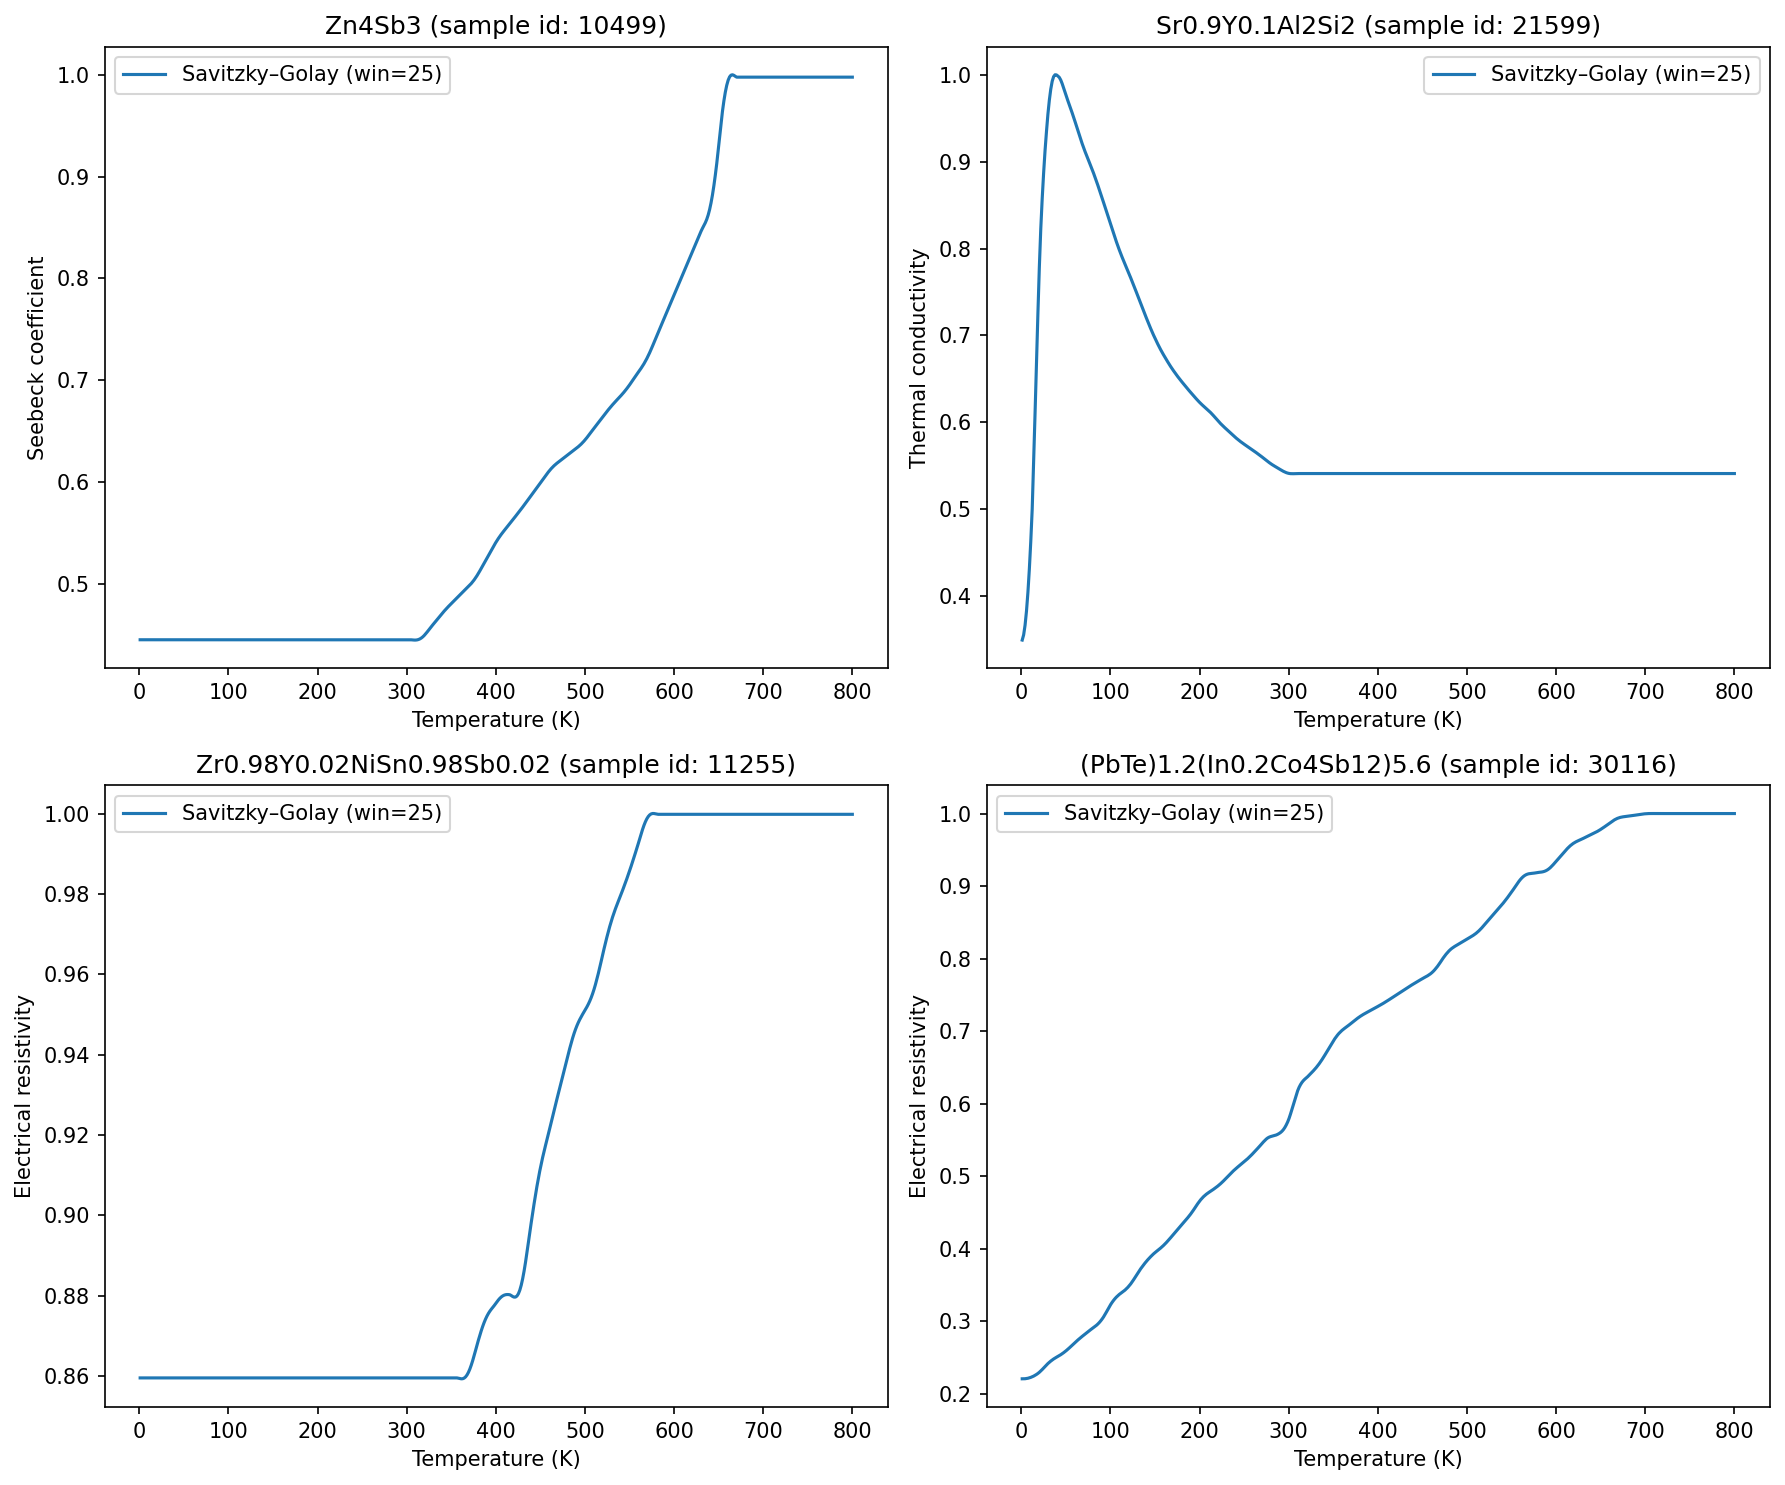

In [139]:
np.random.seed(4)  # 设置随机种子
random_indices = np.random.choice(len(starry_dataset_rebuild), 4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.ravel()

for idx, i in enumerate(random_indices):
    tmp = starry_dataset_rebuild.iloc[i]
    y_new = tmp.property_value

    # _ = axes[idx].plot(tmp.raw_x, tmp.raw_y, 'o', label='Original discrete data')
    _ = axes[idx].plot(x_new, y_new, '-', lw=1.5, label='Savitzky–Golay (win=25)')
    _ = axes[idx].set_xlabel('Temperature (K)')
    _ = axes[idx].set_ylabel(tmp.property)
    _ = axes[idx].legend(loc='best')
    _ = axes[idx].set_title(f'{tmp.formula} (sample id: {tmp.sample_id})')

plt.tight_layout()
plt.show()


### MP data

In [93]:
mp_props = ['band_gap', 'composition', 'density', 'efermi', 'elements', 'energy_per_atom', 'formation_energy_per_atom', 'formula_pretty', 'total_magnetization', 'volume', 'e_total']

mp_data = pd.read_pickle("../raw/materials_project_20250410/mp_inorganic_info.pd.xz")
mp_data = mp_data[mp_data.is_stable]
mp_data = mp_data[mp_props].rename(columns={
    'energy_per_atom': 'final_energy_per_atom',
    'e_total': 'dielectric_constant'
})
mp_data = mp_data.assign(hypermaterial_type='others', composition=mp_data.composition.apply(convert_composition)).dropna(subset=['composition'])

mp_data.shape
mp_data.head(3)

(33973, 12)

,band_gap,composition,density,efermi,elements,final_energy_per_atom,formation_energy_per_atom,formula_pretty,total_magnetization,volume,dielectric_constant,hypermaterial_type
material_id,,,,,,,,,,,,
mp-862690,0.0,(Ac),8.170182,6.128110,[Ac],-68.637479,0.0,Ac,1.065000e-04,184.545401,NaN,others
mp-8566,0.0,(Ag),10.315418,3.120110,[Ag],-21.355877,0.0,Ag,1.200000e-05,69.456950,NaN,others
mp-87,0.0,(Be),1.882615,4.363531,[Be],-3.739413,0.0,Be,1.000000e-07,31.796370,NaN,others


In [94]:
mp_data_rebuild = []
units = {
    'band_gap': 'eV',
    'density': 'g*cm^(-3)',
    'efermi': 'eV',
    'final_energy_per_atom': 'eV/atom',
    'formation_energy_per_atom': 'eV/atom',
    'total_magnetization': 'µB/f.u.',
    'volume': 'Å^3',
    'dielectric_constant': ''
}
mp_props = ['band_gap', 'density', 'efermi', 'final_energy_per_atom', 'formation_energy_per_atom', 'total_magnetization', 'volume', 'dielectric_constant']

for p in mp_props:
    data = mp_data[['formula_pretty', 'composition', 'hypermaterial_type', 'elements', p]].rename(columns={'formula_pretty': 'formula', p: 'property_value'}).dropna(subset=['property_value'])
    data = data.assign(sample_id=0, DOI='-', unit=units[p], temperature=None, property=format_title(p, to_snake=False))
    mp_data_rebuild.append(data)

mp_data_rebuild = pd.concat(mp_data_rebuild)

mp_data_rebuild.head(3)
mp_data_rebuild.shape
mp_data_rebuild.property.value_counts()

,formula,composition,hypermaterial_type,elements,property_value,sample_id,DOI,unit,temperature,property
material_id,,,,,,,,,,
mp-862690,Ac,(Ac),others,[Ac],0.0,0,-,eV,None,Band gap
mp-8566,Ag,(Ag),others,[Ag],0.0,0,-,eV,None,Band gap
mp-87,Be,(Be),others,[Be],0.0,0,-,eV,None,Band gap


(242307, 10)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Dielectric constant           4510
Name: count, dtype: int64

### Merge dataset

In [140]:
qc_ac_te_mp_dataset = pd.concat([qc_ac_dataset_rebuild, starry_dataset_rebuild, mp_data_rebuild])

qc_ac_te_mp_dataset.sample(5)
qc_ac_te_mp_dataset.shape
qc_ac_te_mp_dataset.property.value_counts()

,formula,hypermaterial_type,property,unit,raw_x,raw_y,sample_id,DOI,composition,elements,temperature,property_value
mp-562137,KLiCO3,others,Efermi,eV,NaN,NaN,0,-,"(K, Li, C, O)","[C, K, Li, O]",None,-0.142982
mp-1101867,ZrCuSn,others,Density,g*cm^(-3),NaN,NaN,0,-,"(Zr, Cu, Sn)","[Cu, Sn, Zr]",None,8.126701
mp-1194532,Cd2Ni6Te3PbO18,others,Efermi,eV,NaN,NaN,0,-,"(Cd, Ni, Te, Pb, O)","[Cd, Ni, O, Pb, Te]",None,4.613826
mp-989647,YReN3,others,Final energy per atom,eV/atom,NaN,NaN,0,-,"(Y, Re, N)","[N, Re, Y]",None,-20.89997
mp-1105156,Eu2Si5Pt3,others,Density,g*cm^(-3),NaN,NaN,0,-,"(Eu, Si, Pt)","[Eu, Pt, Si]",None,9.344329


(288968, 12)

property
Band gap                     33973
Density                      33973
Final energy per atom        33973
Formation energy per atom    33973
Total magnetization          33973
Volume                       33973
Efermi                       33959
Seebeck coefficient          20178
Thermal conductivity         14942
Electrical resistivity       11387
Dielectric constant           4510
Magnetic susceptibility        154
Name: count, dtype: int64

In [141]:
qc_ac_te_mp_rebuild = []

for (composition, hypermaterial_type), data in qc_ac_te_mp_dataset.groupby(['composition', 'hypermaterial_type']):
    row_1 = data.iloc[0]
    a = {
        'formula': row_1.formula,
        'hypermaterial_type': hypermaterial_type,
        'temperature': None,
        'composition': composition,
        'elements': row_1.elements,
        'id': ''
    }
    for _id, row in data.iterrows():
        if _id.startswith('mp-'):
            a['id'] = _id
        elif _id.startswith('qa-') and not a['id'].startswith('mp-'):
            a['id'] = _id
        elif a['id'] == '':
            a['id'] = _id
        a[row.property] = row.property_value
        a['temperature'] = row.temperature if row.temperature is not None else a['temperature']

    qc_ac_te_mp_rebuild.append(a)

qc_ac_te_mp_rebuild = pd.DataFrame(qc_ac_te_mp_rebuild).set_index('id')
qc_ac_te_mp_rebuild.head(3)

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:252: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  if not hasattr(other, "X") or not hasattr(other, "symbol"):
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:255: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  x2 = float("inf") if other.X != other.X else other.X
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:252: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  if not hasattr(other, "X") or no

,formula,hypermaterial_type,temperature,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Dielectric constant,Thermal conductivity,Electrical resistivity,Seebeck coefficient,Magnetic susceptibility
id,,,,,,,,,,,,,,,,,
mp-111,Ne,others,None,(Ne),[Ne],11.6898,1.815607,-9.772494,-1.912824,0.0,0.0,18.456188,NaN,NaN,NaN,NaN,NaN
mp-23158,He,others,None,(He),[He],17.6377,0.384324,-13.591344,-0.313901,0.0,0.0,17.293960,NaN,NaN,NaN,NaN,NaN
mp-23155,Ar,others,None,(Ar),[Ar],8.5132,1.720053,-5.482198,-4.858515,0.0,0.0,38.565790,NaN,NaN,NaN,NaN,NaN


In [142]:
# DOS dataset
dos_data = pd.read_pickle("../dos_metal_processed_20240421.pd.xz")
dos_data.head(3)
dos_data.shape

cols_to_take = ['energy', 'density']
dos_data = dos_data[cols_to_take].rename(columns={'energy': 'DOS energy', 'density': 'DOS density'})
qc_ac_te_mp_dos_rebuild = qc_ac_te_mp_rebuild.join(dos_data, how='left')
qc_ac_te_mp_dos_rebuild.to_pickle("../raw/qc_ac_te_mp_dos_norm_reformat_20250529.pd.xz")

qc_ac_te_mp_dos_rebuild.shape
qc_ac_te_mp_dos_rebuild.sample(30)

,reduced_formula,chemical_system,gap,efermi,is_stable,is_metal,density_raw,energy_raw,energy,density,density_norm
material_id,,,,,,,,,,,
mp-569794,Ta,Ta,0.0,5.264594,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.3333, -31.3103, -31.2873, -31.2643, -31.2...","[-6.0, -5.967935871743487, -5.935871743486974,...","[3.830508200593496, 3.9112246648565288, 3.9883...","[0.0620756786476286, 0.06338373727452007, 0.06..."
mp-62,Pa,Pa,0.0,13.102635,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-31.2563, -31.2271, -31.1979, -31.1687, -31.1...","[-6.0, -5.967935871743487, -5.935871743486974,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
mp-582819,Pu,Pu,0.0,14.873514,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-35.0145, -34.9817, -34.9489, -34.9161, -34.8...","[-6.0, -5.967935871743487, -5.935871743486974,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


(10726, 11)

(56401, 19)

,formula,hypermaterial_type,temperature,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Dielectric constant,Thermal conductivity,Electrical resistivity,Seebeck coefficient,Magnetic susceptibility,DOS energy,DOS density
id,,,,,,,,,,,,,,,,,,,
starry-156400,EuBa2Cu3O6.68,others,"[1.0, 2.6012024048096194, 4.202404809619239, 5...","(Eu, Ba, Cu, O)","(Eu, Ba, Cu, O)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.025698124037052628, 0.025698124037052628, 0...","[0.8972017660514989, 0.8972017660514989, 0.897...",NaN,NaN,NaN
starry-92635,GeTe0.95Se0.025S0.025,others,"[1.0, 2.6012024048096194, 4.202404809619239, 5...","(Ge, Te, Se, S)","(Ge, Te, Se, S)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.20261558108008929, 0.20261558108008929, 0.2...",NaN,NaN,NaN
mp-557111,Sr3CaRu2O9,others,None,"(Sr, Ca, Ru, O)","[Ca, O, Ru, Sr]",0.0000,5.420203,3.482820,-7.158687,-2.481132,23.999982,795.402227,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[1.7998207295303557, 1.7027456937002652, 1.612..."
starry-21374,Cu3Sb0.98Ge0.02Se3.2S0.8,others,"[1.0, 2.6012024048096194, 4.202404809619239, 5...","(Cu, Sb, Ge, Se, S)","(Cu, Sb, Ge, Se, S)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.9992733928574661, 0.9992733928574661, 0.999...","[0.4323155584818836, 0.43231555848188363, 0.43...","[0.5578450205574614, 0.5578450205574614, 0.557...",NaN,NaN,NaN
mp-1220791,Nd14Zn43Sn3,others,None,"(Nd, Zn, Sn)","[Nd, Sn, Zn]",0.0000,7.179968,3.331756,-2.602390,-0.386527,0.002160,1199.873146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mp-30763,LiPd2Pb,others,None,"(Li, Pd, Pb)","[Li, Pb, Pd]",0.0000,10.624528,5.794460,-4.415204,-0.419871,0.000001,66.734131,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[0.09102593485361873, 0.0608958753077563, 0.03..."
mp-8282,Ti2N,others,None,"(Ti, N)","[N, Ti]",0.0000,4.924737,6.995941,-13.122373,-1.454285,0.000000,74.005460,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[6.563205793230616, 6.33612562542561, 6.116633..."
starry-22905,Cu0.07Bi0.43Sb1.5Te3,others,"[1.0, 2.6012024048096194, 4.202404809619239, 5...","(Cu, Bi, Sb, Te)","(Cu, Bi, Sb, Te)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.7191932936978096, 0.7191932936978096, 0.719...",NaN,"[0.6689616754188659, 0.6689616754188659, 0.668...",NaN,NaN,NaN
mp-972659,SmCoSi3,others,None,"(Sm, Co, Si)","[Co, Si, Sm]",0.0000,6.133593,7.692879,-6.248741,-0.623150,0.000000,79.472300,NaN,NaN,NaN,NaN,NaN,"[-6.0, -5.967935871743487, -5.935871743486974,...","[0.7443681081663425, 0.6787855165024284, 0.619..."


In [ ]:
qc_ac_te_mp_dos_rebuild.hypermaterial_type.value_counts()

hypermaterial_type
others    55959
IQC         233
IAC         178
DQC          17
DAC          14
Name: count, dtype: int64

/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0, 0.5, 'Count')

Text(0.5, 0, '')

/var/folders/v6/kvz__tj532v10vqfjgv3snqm0000gn/T/ipykernel_50877/1159416111.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


[Text(0, 0, 'Seebeck coefficient'),
 Text(1, 0, 'Thermal conductivity'),
 Text(2, 0, 'Electrical resistivity'),
 Text(3, 0, 'Magnetic susceptibility')]

Text(0.5, 0, '')

Text(0, 0.5, '')

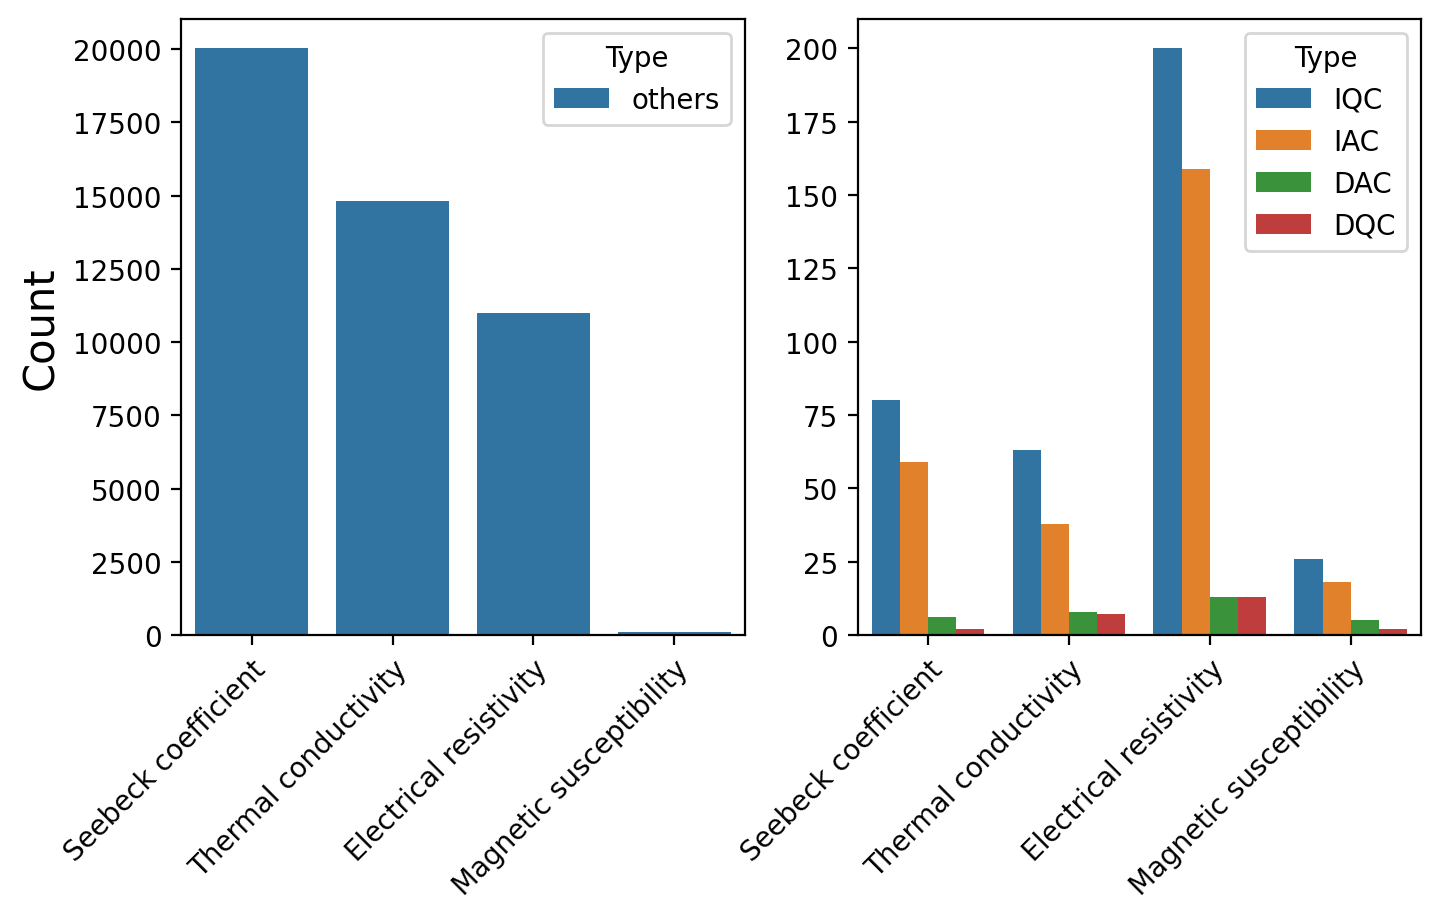

In [134]:
tmp_ = qc_ac_te_mp_dataset.dropna(subset=['temperature'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=False)

tmp = tmp_[tmp_.hypermaterial_type == 'others']
ax = sns.countplot(tmp, x="property", hue='hypermaterial_type', ax=ax1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel(None)
ax.legend(title='Type')

tmp = tmp_[tmp_.hypermaterial_type != 'others']
ax = sns.countplot(tmp, x="property", hue='hypermaterial_type', ax=ax2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title='Type')

---

(Thermal conductivity    5.199338
 dtype: float64,
 Thermal conductivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

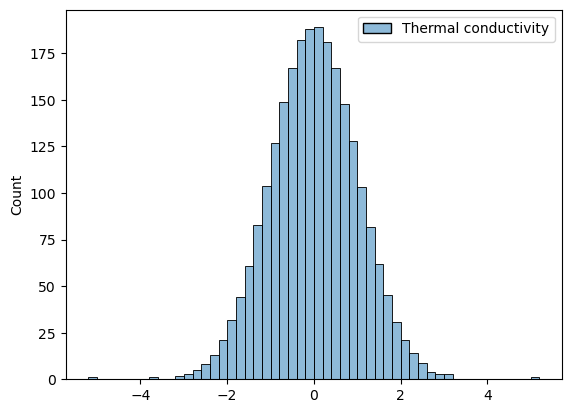

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[['Thermal conductivity']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Electrical resistivity    5.199338
 dtype: float64,
 Electrical resistivity   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

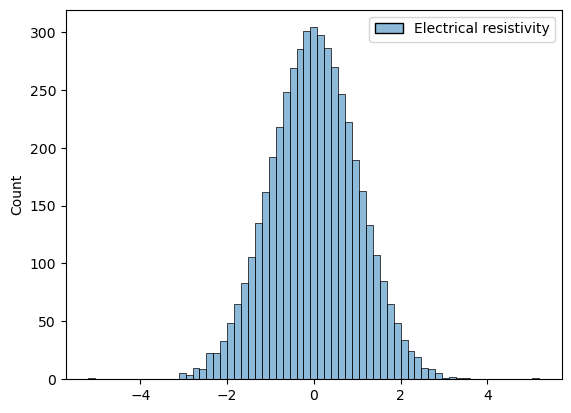

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_dos_rebuild[['Electrical resistivity']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)

(Seebeck coefficient    5.199338
 dtype: float64,
 Seebeck coefficient   -5.199338
 dtype: float64)

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

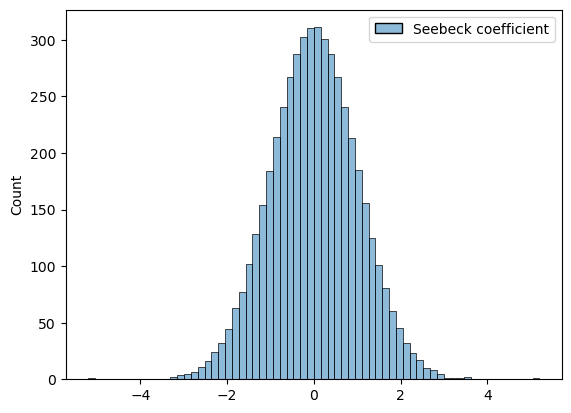

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

a = qc_ac_te_mp_rebuild[['Seebeck coefficient']].dropna().astype(np.float64)
a = qt.fit_transform(a)
a.max(), a.min()
sns.histplot(a)